# Rhys Jennings Data301 Project


Setting up spark workspace

In [ ]:
#library and code setup
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

!pip install gdelt

     |████████████████████████████████| 217.8MB 52kB/s 
     |████████████████████████████████| 204kB 47.5MB/s 
     |████████████████████████████████| 778kB 2.0MB/s 


In [ ]:
#start spark local server
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"

import pyspark
from pyspark import SparkConf, SparkContext

#connects our python driver to a local Spark JVM running on the Google Colab server virtual machine
try:
  conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g")
  sc = SparkContext(conf = conf)
except ValueError:
  #it's ok if the server is already started
  pass

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

Getting Data from GDELT from 01 Jan 2020 until 30 Apr 2020

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from datetime import date, timedelta
import pandas as pd
import gdelt
import os

# set up gdeltpyr for version 2
gd = gdelt.gdelt(version=2)

# multiprocess the query
e = ProcessPoolExecutor()


# generic functions to pull and write data to disk based on date
def get_filename(x):
  date = x.strftime('%Y%m%d')
  return "{}_gdeltdata_knowledge.csv".format(date)

def intofile(filename):
    try:
        if not os.path.exists(filename):
          date = filename.split("_")[0]
          d = gd.Search(date, table='gkg',coverage=False) #not updata at 15mins
          d.to_csv(filename,encoding='utf-8',index=False)
    except:
        print("Error occred")

# pull the data from gdelt into multi files; this may take a long time
dates_before = [get_filename(x) for x in pd.date_range('2020 1 01', '2020 4 30')]
#dates_after = [get_filename(x) for x in pd.date_range('2016 Nov 9','2019 Nov 15')]

results = list(e.map(intofile,dates_before))

/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20200117234500
  warnings.warn(message)


Error occred


/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20200203234500
  warnings.warn(message)


Error occred


/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20200208234500
  warnings.warn(message)


Error occred


/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20200213234500
  warnings.warn(message)


Error occred


/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20200318234500
  warnings.warn(message)


Error occred


/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20200319234500
  warnings.warn(message)


Error occred


Removing errors and loading data into RDD

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
dates_before.remove('20200117_gdeltdata_knowledge.csv')
dates_before.remove('20200203_gdeltdata_knowledge.csv')
dates_before.remove('20200208_gdeltdata_knowledge.csv')
dates_before.remove('20200213_gdeltdata_knowledge.csv')
dates_before.remove('20200318_gdeltdata_knowledge.csv')
dates_before.remove('20200319_gdeltdata_knowledge.csv')
data_before = sqlContext.read.option("header", "true").csv(dates_before)


In [ ]:
#Pulls DocumentIdentifier column and V2Tone column into a RDD
def get_articles(data):
  article_titles = data.rdd.map(lambda row: (row['DocumentIdentifier'], row['V2Tone']))
  return article_titles



articles_and_tone = get_articles(data_before)
dbg(articles_and_tone)

[('http://www.therepublic.com/2020/03/16/virus-outbreak-illinois-3/', '-2.47678018575851,3.09597523219814,5.57275541795666,8.6687306501548,19.1950464396285,0.928792569659443,300'), ('https://www.wlfi.com/content/news/White-House-Avoid-groups-of-more-than-10-stay-away-from-bars-and-restaurants-568837861.html', '-3.08370044052863,1.76211453744493,4.84581497797357,6.6079295154185,24.2290748898678,2.86343612334802,424'), ('http://quadcitiesdaily.com/?p=582650', '-1.2987012987013,0.779220779220779,2.07792207792208,2.85714285714286,23.1168831168831,0.25974025974026,343'), ('https://www.cullmantimes.com/covid-19/alabama-at-virus-cases-calls-to-avoid-large-gatherings/article_92967f08-67c4-11ea-87f0-afd45ec5e3da.html', '-1.08108108108108,3.42342342342342,4.5045045045045,7.92792792792793,28.1081081081081,1.8018018018018,519'), ('https://www.dailyexaminer.com.au/news/are-shoppers-making-the-right-dietary-choice-in-th/3973560/', '1.44092219020173,2.88184438040346,1.44092219020173,4.32276657060519,

Cleaning data to get information I want

In [ ]:
#Pulls title words out of the URL for the article
def retrieve_title_words(url, tone):
  tone_split = tone.split(',')
  title_words = []
  splitted = url.split('/')
  index_longest, title = max(enumerate(splitted), key=lambda x: len(x[1]))
  title = splitted[index_longest].split('-')
  for word in title:
    if word.isalpha():
      title_words.append((word.lower(), (tone_split[1], tone_split[2])))

  return title_words


#Finds the average tone and count for each word
def get_average_tone(tones):
  count = 0 
  positive_tone = 0
  negative_tone = 0 
  for tone in tones:
    count += 1 
    post, neg = tone
    positive_tone += float(post)
    negative_tone += float(neg)

  average_positive = positive_tone / count
  average_negative = negative_tone / count

  return (average_positive, average_negative, count)


words = articles_and_tone.flatMap(lambda article: retrieve_title_words(article[0], article[1]))
grouped_words = words.groupByKey()
average_values = grouped_words.map(lambda word: (word[0], (get_average_tone(word[1]))))

#Results in a tuple with the word, average positive value, average negative value, and the count
dbg(average_values)


[('stay', (2.395440680170068, 3.929293288838827, 1437)), ('away', (3.0145291343589657, 3.599021803965823, 526)), ('from', (2.6277298892901095, 4.09292678329845, 6587)), ('stop', (2.261733015122269, 4.789064678182165, 901)), ('for', (2.719459856631577, 3.6934682799038074, 22774)), ('know', (2.6041378003368956, 3.876983610796045, 782)), ('workouts', (3.6246962114697148, 2.1163644245798903, 42)), ('florida', (2.053303481157232, 4.371737770970795, 1320)), ('ever', (2.9306901861862507, 2.786778099779826, 350)), ('states', (2.327423297905348, 4.094844334517046, 971)), ('primary', (2.4233699461904914, 2.7742600471979006, 603)), ('executive', (2.9204878919521002, 2.9571708441665723, 301)), ('they', (2.535427644371628, 4.006933091041259, 744)), ('aims', (3.066028588277449, 3.0932096274937373, 192)), ('anna', (3.3887938205020043, 2.774350123145253, 39)), ('wintour', (2.8358670414140588, 4.056829438180544, 13)), ('pulse', (2.725081606176108, 3.135096511324566, 14)), ('before', (2.5110289717834333

In [ ]:
#Get rid of words that appear less than 10 times
frequent_words = average_values.filter(lambda word: word[1][2] >= 10)

#To check the algorithm is currently working by showing ordered positive, negative, and common words. 
max_positive_words = frequent_words.takeOrdered(10, lambda word: -1 * word[1][0])
max_negative_words = frequent_words.takeOrdered(10, lambda word: -1 * word[1][1])
most_common_words = frequent_words.takeOrdered(10, lambda word: -1 * word[1][2])
print(max_positive_words)
print(max_negative_words)
print(most_common_words)

[('marnie', (12.34654377880187, 2.3152073732718934, 10)), ('deuce', (11.238801531541537, 4.558380729340915, 14)), ('charms', (9.998338449903763, 2.131270385521205, 17)), ('romes', (9.60643731172406, 0.5844720006318618, 11)), ('glaad', (8.560753799074352, 1.4871361089752777, 10)), ('dancetogether', (8.360128617363342, 1.2861736334405103, 11)), ('naacp', (8.172311822919497, 1.5131879235012913, 27)), ('euromillions', (8.17028294566593, 0.6954297500593026, 18)), ('perishers', (8.0, 2.0, 13)), ('delicious', (7.975082380385072, 1.4575488243746577, 19))]
[('terroristic', (0.0, 17.006802721088402, 11)), ('munchausen', (1.2245693495693486, 15.108590733590757, 13)), ('cyberstalked', (2.38095238095238, 12.8571428571429, 11)), ('cuffs', (1.3417052735343917, 12.811245996425619, 11)), ('sucking', (0.27169765241017174, 12.35064448690106, 17)), ('bacterial', (2.2487324355292104, 11.493026520207055, 24)), ('sudesh', (2.097818859243048, 11.481523312124763, 11)), ('allergies', (1.3707543670643563, 11.099

Load Data into a Dataframe to use with KMeans

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf

In [ ]:
dataframe = frequent_words.map(lambda x: (x[0], x[1][0], x[1][1], x[1][2], [x[1][0], x[1][1]]))
schemaWords = (sqlContext.createDataFrame(dataframe)
                            .withColumnRenamed("_1", "word")
                            .withColumnRenamed("_2", "positive")
                            .withColumnRenamed("_3", "negative")
                            .withColumnRenamed("_4", "count")
                            .withColumnRenamed("_5", "features"))

new_schema = ArrayType(DoubleType(), containsNull = False)
udf_foo = udf(lambda x:x, new_schema)


total_schema = schemaWords.withColumn("features",udf_foo("features"))

total_schema.printSchema()
total_schema.show()

root
 |-- word: string (nullable = true)
 |-- positive: double (nullable = true)
 |-- negative: double (nullable = true)
 |-- count: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = false)

+----------+------------------+------------------+-----+--------------------+
|      word|          positive|          negative|count|            features|
+----------+------------------+------------------+-----+--------------------+
|      stay| 2.395440680170068| 3.929293288838827| 1437|[2.39544068017006...|
|      away|3.0145291343589657| 3.599021803965823|  526|[3.01452913435896...|
|      from|2.6277298892901095|  4.09292678329845| 6587|[2.62772988929010...|
|      stop| 2.261733015122269| 4.789064678182165|  901|[2.26173301512226...|
|       for| 2.719459856631577|3.6934682799038074|22774|[2.71945985663157...|
|      know|2.6041378003368956| 3.876983610796045|  782|[2.60413780033689...|
|  workouts|3.6246962114697148|2.1163644245798903|   

Kmeans Clustering

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans().setK(20).setSeed(1).setFeaturesCol("features")
model=kmeans.fit(total_schema)
transformed = model.transform(total_schema).select("word", "positive","negative", "prediction")
rows=transformed.collect()



In [ ]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

df_predd_rdd = df_pred.rdd

+----------+------------------+------------------+----------+
|      word|          positive|          negative|prediction|
+----------+------------------+------------------+----------+
|      stay| 2.395440680170068| 3.929293288838827|         7|
|      away|3.0145291343589657| 3.599021803965823|        15|
|      from|2.6277298892901095|  4.09292678329845|        14|
|      stop| 2.261733015122269| 4.789064678182165|        13|
|       for| 2.719459856631577|3.6934682799038074|         7|
|      know|2.6041378003368956| 3.876983610796045|         7|
|  workouts|3.6246962114697148|2.1163644245798903|        18|
|   florida| 2.053303481157232| 4.371737770970795|        13|
|      ever|2.9306901861862507| 2.786778099779826|         9|
|    states| 2.327423297905348| 4.094844334517046|         7|
|   primary|2.4233699461904914|2.7742600471979006|         9|
| executive|2.9204878919521002|2.9571708441665723|         9|
|      they| 2.535427644371628| 4.006933091041259|         7|
|      a

In [ ]:
centers = model.clusterCenters()
for center in centers:
  print(center)

[3.80472908 4.17104443]
[1.50853218 9.43027239]
[1.57297714 5.67783225]
[2.39663339 1.7927907 ]
[1.71761586 3.98856086]
[4.44607353 2.28892777]
[4.05398964 1.30146586]
[2.43856013 3.67277679]
[2.32646702 5.22430354]
[2.71800167 2.84860593]
[3.67191161 2.97325759]
[5.17951548 3.35610197]
[2.78386488 6.02617692]
[2.17394483 4.51496392]
[2.86246603 4.37645724]
[3.05144104 3.4697908 ]
[6.27711092 1.62870564]
[1.75168284 7.16799053]
[3.30338024 2.2120929 ]
[1.92442703 2.88190913]


We can see from the centers that center (1) has the most negative words, and (16) has the most positive words

In [ ]:
top_negative_words = df_predd_rdd.filter(lambda x: x[3] == 1)
print(top_negative_words.collect())

[Row(word='defendant', positive=1.3472007705545277, negative=10.207283247661225, prediction=1), Row(word='deli', positive=1.0832528554667695, negative=8.593571885895885, prediction=1), Row(word='slapped', positive=1.6869489833923592, negative=8.435128012945627, prediction=1), Row(word='weinstein', positive=1.796429539985591, negative=8.531942413066918, prediction=1), Row(word='stabbing', positive=0.821359842353265, negative=9.43590603957284, prediction=1), Row(word='rapist', positive=1.3266075299801865, negative=8.540918010647284, prediction=1), Row(word='brutality', positive=1.5651507437920802, negative=8.510610169440083, prediction=1), Row(word='estranged', positive=1.3226337240318609, negative=9.313446988978198, prediction=1), Row(word='martyr', positive=2.488710042914722, negative=10.25171394031048, prediction=1), Row(word='millane', positive=2.8291074705892907, negative=8.478272157672732, prediction=1), Row(word='prioritised', positive=2.9782764763753318, negative=11.0497487303570

In [ ]:

top_positive_words = df_predd_rdd.filter(lambda x: x[3] == 16)
print(top_positive_words.collect())

[Row(word='wordpress', positive=5.709303056954797, negative=0.6383927098056422, prediction=16), Row(word='exes', positive=5.455027421089452, negative=1.362237958926692, prediction=16), Row(word='granny', positive=5.828502966871514, negative=0.7612496938334388, prediction=16), Row(word='bafta', positive=7.287566575299472, negative=1.3821954470079238, prediction=16), Row(word='benji', positive=6.723791789249472, negative=2.1715850551334355, prediction=16), Row(word='mjs', positive=7.055214723926382, negative=0.6134969325153373, prediction=16), Row(word='heirs', positive=5.71431409776346, negative=0.42016806722689076, prediction=16), Row(word='arts', positive=5.491399935467313, negative=1.9621798139363333, prediction=16), Row(word='skyline', positive=6.123425449507162, negative=1.551041920449358, prediction=16), Row(word='calf', positive=6.247916931379648, negative=2.118383707501421, prediction=16), Row(word='charlize', positive=7.25721091887854, negative=2.0218994436534867, prediction=16

Plotting Results:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

x=df_predd_rdd.map(lambda word: word[2])
y=df_predd_rdd.map(lambda word: word[1])
labels = df_predd_rdd.map(lambda word: word[3])


df_for_graph = pd.DataFrame(dict(x=x.collect(), y=y.collect(), category=labels.collect()))
print(df_for_graph)



              x         y  category
0      3.929293  2.395441         7
1      3.599022  3.014529        15
2      4.092927  2.627730        14
3      4.789065  2.261733        13
4      3.693468  2.719460         7
...         ...       ...       ...
13965  3.362379  2.710733        15
13966  2.616712  3.901618        10
13967  4.626895  2.430155        13
13968  1.939724  1.986129         3
13969  2.473549  2.913396         9

[13970 rows x 3 columns]


In [ ]:
x1 = []
y1 = []
for i in centers:
  
  x1.append(i[1])
  y1.append(i[0])



All Data with centers visuallized

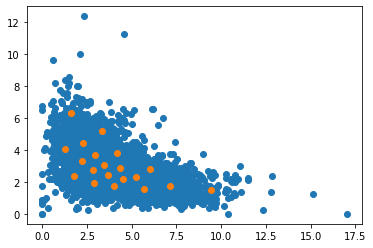

In [ ]:
import matplotlib.pyplot as plt
x = frequent_words.map(lambda word: word[1][1])
y = frequent_words.map(lambda word: word[1][0])

plt.scatter(x.collect(),y.collect())

plt.scatter(x1,y1)


Plotting Data with clusters using plotnine

              x         y  category
0      3.929293  2.395441         7
1      3.599022  3.014529        15
2      4.092927  2.627730        14
3      4.789065  2.261733        13
4      3.693468  2.719460         7
...         ...       ...       ...
13965  3.362379  2.710733        15
13966  2.616712  3.901618        10
13967  4.626895  2.430155        13
13968  1.939724  1.986129         3
13969  2.473549  2.913396         9

[13970 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/usr/local/lib/python3.6/dist-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])


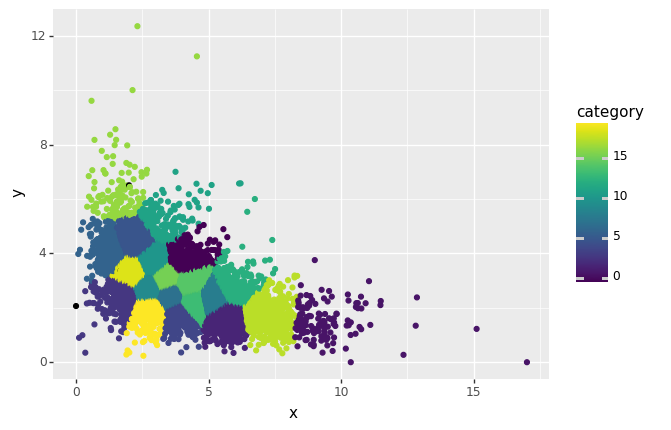

<ggplot: (8754480180239)>


In [ ]:
from plotnine import *



x=df_predd_rdd.map(lambda word: word[2])
y=df_predd_rdd.map(lambda word: word[1])
labels = df_predd_rdd.map(lambda word: word[3])

df_for_graph = pd.DataFrame(dict(x=x.collect(), y=y.collect(), category=labels.collect()))

print(df_for_graph)
g = ggplot(df_for_graph, aes(x='x', y='y', color='category')) + geom_point(stat='summary')
print(g)